# Stitching of 118 images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import gtsam
import gtsam.utils.plot as gtsam_plot

from Mosaic import Mosaic
from Features import Features
from Pose2D import Pose2D
from Homography import Homography
from helper import *
from GTHelper import GTHelper

%load_ext autoreload
%autoreload 2

In [4]:
mosaic = Mosaic()
mosaic.read_imgs_from_folder("118_images/", resize_factor = 1, show_imgs = False)
features = Features()
features.create_sift()
mosaic.apply_clahe()
keypoints_list, descriptor_list = features.detect_keypoints(mosaic.clahe_images,
                                                            mosaic.num_imgs_mosaic,
                                                            False)

In [5]:
MATCH_THRESH = 0.8
RANSAC_THRESH = 10
INLIER_THRESH = 12

In [6]:
homographies_temporal = [np.identity(3)]
temporal_match_dict = {}
for i in range(mosaic.num_imgs_mosaic-1):
    src_points, dst_points, matches = features.match_features(mosaic.mosaic_imgs_gray[i], 
                                                                mosaic.mosaic_imgs_gray[i+1],
                                                                keypoints_list[i],
                                                                keypoints_list[i+1],
                                                                descriptor_list[i],
                                                                descriptor_list[i+1],
                                                                match_threshold=MATCH_THRESH,
                                                                plot=False)
    
    H, inliers_mask = cv2.estimateAffinePartial2D(src_points, dst_points,None,cv2.RANSAC, RANSAC_THRESH)
    H = np.append(H, [[0,0,1]], axis=0)

    is_good, covar = Homography.is_good(H, inliers_mask, INLIER_THRESH, src_points, dst_points)
    if not is_good:
        print(f"Match Failed: {i}-->{i+1}")
        print("inliers: ", np.count_nonzero(inliers_mask))
        break
    
    temporal_match_dict[(i, i+1)] = {"H": H, "error": covar}
    
    homographies_temporal.append(H)

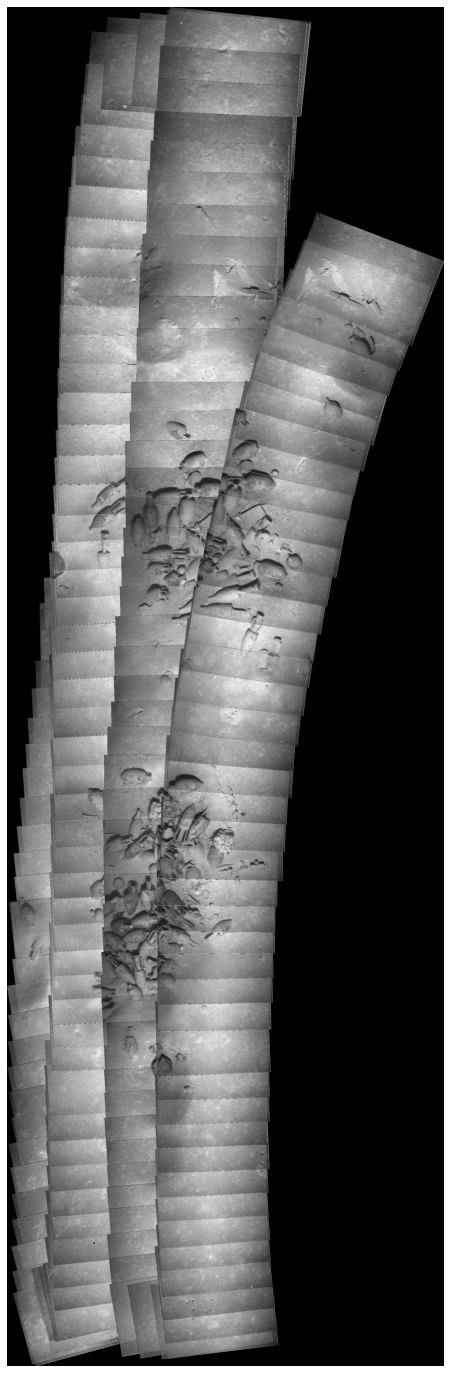

In [8]:
homographies_for_mosaic = [np.linalg.inv(homographies_temporal[i]) for i in range(mosaic.num_imgs_mosaic)]
for i in range(1, mosaic.num_imgs_mosaic):
    homographies_for_mosaic[i] = homographies_for_mosaic[i-1] @ \
                                 homographies_for_mosaic[i]
    
min_x, min_y, max_x, max_y = mosaic.calculate_min_max_coordinates(homographies_for_mosaic)
warped_images = mosaic.warp_images(homographies_for_mosaic, min_x, min_y, max_x, max_y, False)
mosaic.show_panorama(warped_images, homographies_for_mosaic, fig_size=(25, 25))

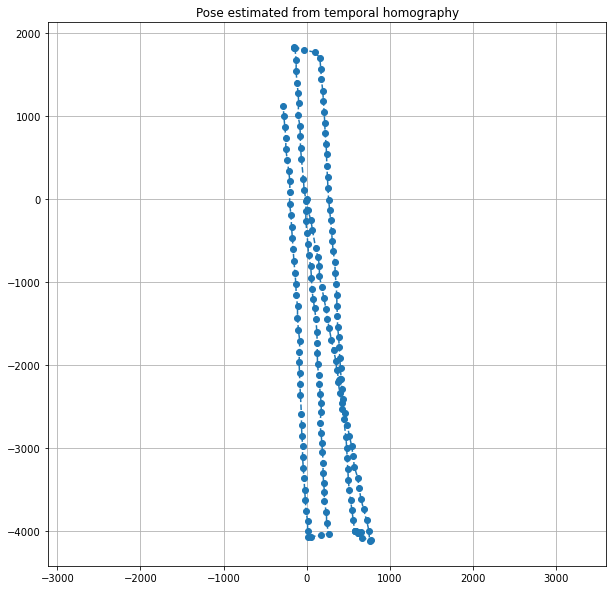

In [9]:
px = np.array([])
py = np.array([])
initial_pose_estimates = Pose2D.get_initial_pose_estimates(homographies_temporal)

for x, y, theta in initial_pose_estimates:
    # print(np.degrees(theta))
    px = np.append(px, x)
    py = np.append(py, y)

plt.figure(figsize=(10, 10))
plt.plot(px, py, "--o")
plt.axis("equal")
plt.grid(visible=True)
plt.title("Pose estimated from temporal homography")
plt.show()